Why DIRECT? in this paper, the threats have been simplified to circular boundaries. In real life, the boundaries will be irregular, and will have no explicit differentiable expression avalible.

In [92]:
from scipy.optimize import direct, Bounds
import numpy as np

s# Deriving the cost function.

## Finding an initial cost function

* Consider problem in two dimensions.
* Route consists of start and endpoints with a number of intermediate waypoints.
* The coordinates of the waypoints are the optimization variables.
* We want the distance flown to be minimal, so calculate Euclidian distance of the route, and label it $L$.
* Determine if any of our path lies within a threat, and the length of the path within the threat.

If the route lies within the $i$-th threat for a distance $L_i$ then the cost of the route can be expressed as

$C = L + \displaystyle\sum_{i} \rho _i L_{i}^{p}$

$\rho _i$ is a penalty parameter for the $i$-th threat.

In other words, the cost is the total length of the path, plus the length of each segment within a threat multiplied by the penalty parameter associated with that particular threat.

## Defining "leg" length
We have $n$ waypoints $w_j = (w_{j1}, w_{j2})$ for $j = 1, ..., n$, let the start and end points be $w_0, w_{n+1}$ respectively. We can define the vector $u_j = w_j - w_{j-1}$ which helps us defined the length of any given leg as 

$l_j = \sqrt{(u_{j1}^2 + u_{j2}^2)}$

## Determining threat violations

We  will use linear interpoliation to estimate where leg $j$ intersects with threat $i$. 

Consider $\sigma _{max}$ to be the maximum step size for use in sampling any leg of a route. This means that the number of samplings points along leg $j$ is $K_{max} = \lceil l_j / \sigma _{max} \rceil$.Let the normalized step size be $\delta \lambda = \frac{1}{K_{max}}$ and let $u_k$ be a sampled point in the leg.

$u_k = w_{j-1} + k \delta \lambda (w_j - w_{j-1})$

$k = [0, ..., K_{max}]$.

Suppose we have an indicator function of position, $T_i$, such that $T_i(u_k) \leq 0$ indicates that the sampled position within the leg, $u_k$ is within threat i, and confirms that the position is not within the threat otherwise. Using what we have defined so far can create an algorithm for calculating "in threat" length, denoted $l_{ji}$.

1. Find $l_j$, $l_i$. Set $i_{ji} = 0$  
2. Set $k=0$, $K_{max}=(\delta \lambda)^{-1}$  
3. If $T_i (u_0) \leq 0$ then $\lambda _b = 0$  
4. For $k = 1, ..., K_{max}$   
5.  ---> If $T_i (u_k) \leq 0$ and $T_i (u_{k-1}) > 0$ then  
6.  ------->  set $\kappa = T_i(u_k)/(T_i(u_k)-T_i(u_{k-1})), \lambda _b = (k - \kappa)\delta \lambda$  
7.  ---> If $T_i (u_k) > 0$ and $T_i (u_{k-1}) \leq 0$ then  
8.  ------->  set $\kappa = T_i(u_k)/(T_i(u_k)-T_i(u_{k-1})), \lambda _e = (k - \kappa)\delta \lambda$  
9.  ------->  set $l_{ji} + (\lambda _e - \lambda _b) l_j$  
10.  ---> If $T_i (u_{K_{max}}) \leq 0$ then   
11.  -------> set $l_{ji} = l_{ji} + (1- \lambda _b )l_j$  

Line-by-line explanation:

1. Find the length of the current leg. Initialize "in threat" distance accumulator as 0.
2. Set up a counter at 0, and set $K_{max} = (\delta \lambda)^{-1}$. Recall: $\delta \lambda = 1/K_{max}$. So we're just initializing $K_{max}$ with it's own value.
3. Determine if our starting point is within the threat.
4. For k = 1 -> $K_{max}$ to start checking each point along the leg.
5. Detect if the path passed INTO the threat.
6. Calculate the location of the boundary with interpolation. $\kappa$ is the fractional interpolation value, it represents a number from 0-1 that says where the boundary crossing lies between two samples on the leg. After that, we calculate where the crossing occurs on the entire leg. We know the crossing occured when we took the k-th step. So $k-\kappa$ is the number of steps to where the boundary is, and $\delta \lambda$ is our step size.
7. Detect if the passed passed OUT of the threat
8. Perform the same interpolation as step 6. Set $\lambda _e$ instead which is the exit position.
9. Since we've exited, we can calculate the in-threat distance, $l_{ji}$. $(\lambda _e - \lambda _b)$ represents the normalized distance in the threat zone and multiplying it by $l_j$ converts it to real distance. Add it to the accumulator. 
10. Determine if exit point is inside the threat
11. Do a similar calculation to step 9, add it to the accumulator.
 
## Defining constraints
Two additional features are included to enhance the realism of the simulation. Firstly, you can restrict routes that involve sharp turns, and secondly, you can set a limit on the distance between waypoints.

The angle between successive legs is defined as $\phi _j$. Given by

$\phi _j = cos^{-1}\{\frac{u_j ^T u_{j+1}}{||u_j|| ||u_{j+1}||}\}$

$\phi _{max}$ is the limiting turn angle, and $l_{min}$ is the minimum leg-length. We can define a final extended cost function.

$$
C = \sum_{j=1}^{n+1} ( l_j + \mu (( l_{min} - l_j )_+ )^2 + \sum_{j=1}^m \rho _i l_{ji}^p ) + \sum_{j=1}^n v ((\phi _j - \phi _{max})_+)^2
$$

$\mu$ and $v$ are positive penalty parameters for controling minimum leg length and turn angle.

Parameters for the cost function: $l_{min}, \phi _{max}, \mu, \nu$
Function will need list of waypoints, start and endpoint, and threat list.

In [ ]:
# Cost function
def cost(x, start, end, threats, lmin, phi_max, mu, nu, p):
    waypoints = np.vstack([start, x.reshape(-1, 2), end]) # add start and stop points to our stack
    total_cost = 0 # accumulator for cost

    legs = np.diff(waypoints, axis=0) # gets differences of each leg
    leg_lengths = np.linalg.norm(legs, axis=1) # convert differences to magnitudes

    if len(legs) >= 2:
        turn_angles = np.zeros(len(legs) - 1)
        for j in range(1, len(legs)):
            u_prev = legs[j-1]
            u_curr = legs[j]
            cos_phi = np.dot(u_prev, u_curr) / (np.linalg.norm(u_prev) * np.linalg.norm(u_curr))
            turn_angles[j-1] = np.arccos(np.clip(cos_phi, -1, 1))
    else:
        turn_angles = np.zeros(0)  # Empty array for no turns
    
    # First component of cost, total path length
    total_cost += np.sum(leg_lengths)

    # Penalty for leg length 
    short_leg_penalty = np.sum(mu * np.maximum(lmin - leg_lengths, 0) ** 2)
    total_cost += short_leg_penalty

    # Threat penalty by in-threat distance
    for i, (threat_centre, threat_radius) in enumerate(threats): # Check each threat
        l_ji = 0.0 # Accumulator for this threat
        for j in range(len(legs)):
            l_ji += in_threat_distance(waypoints[j], waypoints[j+1], threat_centre, threat_radius, sigma_max=4)
        total_cost += l_ji ** p # p = threat penalty parameter.
    
    # Turn angle penalty
    turn_penalty = np.sum(nu * np.maximum(turn_angles - phi_max, 0) ** 2)
    total_cost += turn_penalty

    return total_cost

def T_i(point, center, radius):
    return np.linalg.norm(point - center) - radius

def in_threat_distance(start, end, center, radius, sigma_max):  # Center and radius are components of the threat.
    l_j = np.linalg.norm(end - start) # start and end are vectors.
    l_ji = 0.0
    K_max = int(np.ceil(l_j / sigma_max))
    delta_lambda = 1 / K_max
    lambda_b = None

    # If starting inside threat zone
    if T_i(start, center, radius) <= 0:
        lambda_b = 0

    for k in range(1, K_max+1):
        lambda_k = k * delta_lambda
        u_k = start + lambda_k * (end - start)
        T_k = T_i(u_k, center, radius)

        u_k_prev = start + (lambda_k - delta_lambda) * (end - start)
        T_k_prev = T_i(u_k_prev, center, radius)

        # Entering threat zone
        if T_k <= 0 and T_k_prev > 0:
            kappa = T_k / (T_k - T_k_prev)
            lambda_b = (k - kappa) * delta_lambda
        
        # Exiting threat zone
        if T_k > 0 and T_k_prev <= 0:
            kappa = T_k / (T_k - T_k_prev)
            lambda_e = (k - kappa) * delta_lambda
            l_ji += (lambda_e - lambda_b) * l_j
            lambda_b = None
    
    # If ending inside threat zone
    if T_i(end, center, radius) <= 0 and lambda_b is not None:
        l_ji += (1.0 - lambda_b) * l_j
    
    return l_ji

# Approach 1 - Seperate calculation of outward and return legs
Route is from (50, 30) to (167, 107)
We will use two waypoints:
(108 $\pm$ 60, 68 $\pm$ 40), (109 $\pm$ 60, 69 $\pm$ 40)

===== Running Cost Function Tests =====

Test 1: Straight line, no threats
Cost: 100.00 (Expected: 100.00)

Test 2: One waypoint, no threats
Cost: 101.98 (Expected: 101.98)

Test 3: Short leg penalty
Cost: 181.00 (Expected: ~181.00)

Test 4: Sharp turn penalty
Cost: 173.79 (Expected: ~150.62)

Test 5: Threat intersection
Cost: 8100.00 (Expected: ~8100.00)

All tests passed successfully!

===== Running Visualization Test =====
Route cost: 198236.24


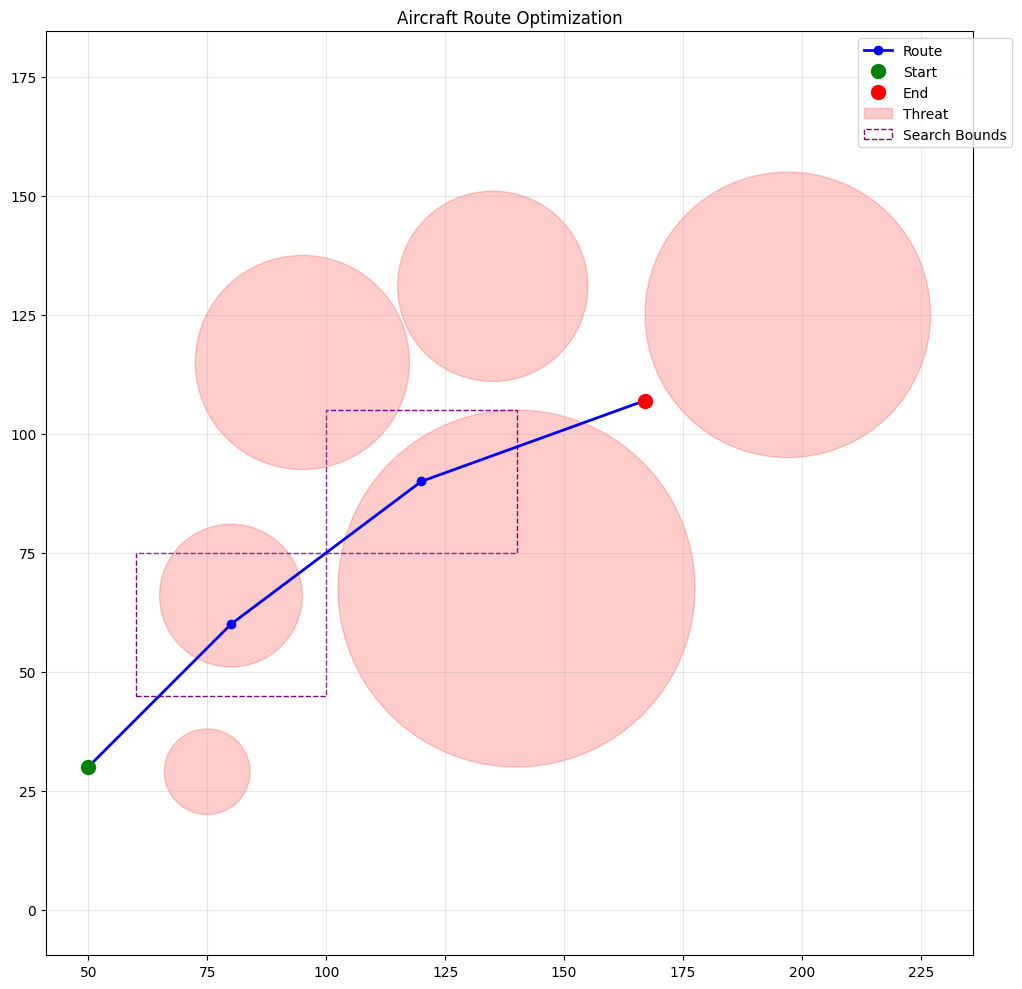

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

# Define threats from the paper
threats = [(np.array([75,  29]),    9),
           (np.array([80,  66]),    15),
           (np.array([95,  115]),   22.5),
           (np.array([135, 131]),   20),
           (np.array([140, 67.5]),  37.5),
           (np.array([197, 125]),   30)]

def test_cost_function():
    """Run comprehensive tests on the cost function"""
    print("===== Running Cost Function Tests =====")
    
    # Test 1: Straight line with no threats
    print("\nTest 1: Straight line, no threats")
    start = np.array([0, 0])
    end = np.array([100, 0])
    c = cost(np.array([]), start, end, [], 10, np.radians(45), 1, 1, 3)
    print(f"Cost: {c:.2f} (Expected: 100.00)")
    assert np.isclose(c, 100.0)
    
    # Test 2: Single waypoint with no threats
    print("\nTest 2: One waypoint, no threats")
    x = np.array([50, 10])
    c = cost(x, start, end, [], 10, np.radians(45), 1, 1, 3)
    expected = np.linalg.norm(x-start) + np.linalg.norm(end-x)
    print(f"Cost: {c:.2f} (Expected: {expected:.2f})")
    assert np.isclose(c, expected)
    
    # Test 3: Short leg penalty
    print("\nTest 3: Short leg penalty")
    x = np.array([1, 0])  # Very short leg
    c = cost(x, start, end, [], 10, np.radians(45), 1, 1, 3)
    penalty = 1 * (10 - np.linalg.norm(x-start))**2
    expected = np.linalg.norm(x-start) + np.linalg.norm(end-x) + penalty
    print(f"Cost: {c:.2f} (Expected: ~{expected:.2f})")
    assert c > 100
    
    # Test 4: Sharp turn penalty
    print("\nTest 4: Sharp turn penalty")
    x = np.array([50, 0, 50, 50])  # 90-degree turn
    c = cost(x, start, end, [], 10, np.radians(45), 1, 1, 3)
    turn_penalty = 1 * max(0, np.radians(90)-np.radians(45))**2
    expected = 50+50+50 + turn_penalty
    print(f"Cost: {c:.2f} (Expected: ~{expected:.2f})")
    assert c > 150
    
    # Test 5: Threat intersection
    print("\nTest 5: Threat intersection")
    threat = [(np.array([50, 0]), 10)]
    c = cost(np.array([]), start, end, threat, 10, np.radians(45), 1, 1, 3)
    in_threat = 20**3  # 20km through threat, p=3
    expected = 100 + in_threat
    print(f"Cost: {c:.2f} (Expected: ~{expected:.2f})")
    assert c > 8000  # Large penalty expected
    
    print("\nAll tests passed successfully!")

def visualize_route(waypoints, start, end, threats, bounds=None):
    """Visualize the route with threats and search bounds"""
    plt.figure(figsize=(12, 10))
    
    # Plot route
    path = np.vstack([start, waypoints.reshape(-1, 2), end])
    plt.plot(path[:,0], path[:,1], 'b-o', lw=2, label='Route')
    plt.plot(start[0], start[1], 'go', ms=10, label='Start')
    plt.plot(end[0], end[1], 'ro', ms=10, label='End')
    
    # Plot threats
    for i, (center, radius) in enumerate(threats):
        plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2, 
                            label='Threat' if i==0 else None))
    
    # Plot search bounds if provided
    if bounds is not None:
        bounds = bounds.reshape(2, -1)  # Ensure proper shape
        for i in range(0, bounds.shape[1], 2):
            x_min, y_min = bounds[0,i], bounds[0,i+1]
            x_max, y_max = bounds[1,i], bounds[1,i+1]
            width = x_max - x_min
            height = y_max - y_min
            rect = Rectangle((x_min, y_min), width, height,
                            linewidth=1, edgecolor='purple',
                            facecolor='none', linestyle='--',
                            label='Search Bounds' if i==0 else None)
            plt.gca().add_patch(rect)
    
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("Aircraft Route Optimization")
    plt.tight_layout()
    plt.show()

def test_with_visualization():
    """Test with visualization using paper's parameters"""
    print("\n===== Running Visualization Test =====")
    start = np.array([50, 30])
    end = np.array([167, 107])
    
    # Example waypoints (2 waypoints for Approach 1)
    waypoints = np.array([80, 60, 120, 90])
    
    # Define search bounds (±20km x, ±15km y as in paper)
    bounds = np.array([
        [80-20, 60-15, 120-20, 90-15],  # Lower bounds
        [80+20, 60+15, 120+20, 90+15]    # Upper bounds
    ])
    
    # Calculate and display cost
    c = cost(waypoints, start, end, threats, 10, np.radians(42.5), 1, 1, 3)
    print(f"Route cost: {c:.2f}")
    
    # Visualize
    visualize_route(waypoints, start, end, threats, bounds)

if __name__ == "__main__":
    # First run the verification tests
    test_cost_function()
    
    # Then run the visualization test
    test_with_visualization()